In [1]:
%pylab inline
import scipy
import webbpsf
import astropy.units as u
import poppy
import pysiaf
from pysiaf.siaf import plot_main_apertures

webbpsf.setup_logging('None')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Plot Wavefront Error Field Dependence over the JWST Instruments

This plotting code is more convoluted than would be ideal...

## Display the input field points from ISIM cryovac testing

In [2]:
def disp1row(inst, row, wave, pupilmask, size=.6, vmax=300, verbose=True, ax=None, **kwargs):
    """ Display one WFE field point based on a row in the Zernike table
    """

    # Look up V2V3 coords for the defined field point, use sciaf machinery to cast to detector coords,
    # and setup the webbpsf instrument to that detector coords. 
    v2 = row["V2"]
    v3 = row["V3"]

    
    if inst.name=='NIRCam' and inst.channel=='short':
        # we may have to toggle across the 4 SW detectors as well.
        # Convert from the format used in the zernikes table to what WebbPSF wants
        inst.detector='NRC'+row['DETECTOR'][6] + row['DETECTOR'][10]
        
        if inst.image_mask is not None: # for coronagraphy we have to toggle masks as well as detectors
            if inst.detector=='NRCA2':
                inst.image_mask = 'MASK210R'
            else:
                inst.image_mask = 'MASKSWB'
        print(f"disp1row: set det={inst.detector}")
        
    elif inst.name=='NIRSpec':
        # toggle between the two NIRSpec detectors
        inst.detector='NRS'+row['DETECTOR'][-1]
        
    
    det_pos = inst._detector_geom_info.aperture.tel_to_sci(v2*60, v3*60)
    det_pos = tuple(int(np.round(i)) for i in det_pos)
    
    if verbose: 
        print(row['field_point_name'], v2, v3, det_pos)
    
    
    if det_pos[0] < 0 or det_pos[1] < 0: 
        return (v2,v3, None)

    
    wfe_src='ISIM CV Measurement' if not(inst.name=='NIRCam' and inst.pupil_mask is not None and 
                                         'MASK' in inst.pupil_mask) else "Computed from Zemax"

    # Display the OPD
    
    label = "{det_pos}: {fp}".format(det_pos=det_pos, fp=row['field_point_name'])
    im = disp1fieldpoint(inst, det_pos, wave, pupilmask, size=size, label=label, vmax=vmax, ax=ax, 
                         wfe_src=wfe_src, **kwargs) 
    
    return (v2,v3, im)


def disp1fieldpoint(inst, det_pos, wave, pupilmask, size=0.6,  vmax=300, label=True, labelfontsize=7,
                   labelvertalignment='bottom', ax=None, labelvoffset=0, wfe_src= None):
    """Display an OPD at a specified arbitrary field point, via lookup, interpolation, or extrapolation"""
    inst.detector_position = det_pos
    aberration = inst._get_aberrations()
    opd = aberration.get_opd(wave)
    opd *= pupilmask # Mask out area outside the entrance pupil
    
    opd *= 1e9       # convert meters to nm
    rms = np.sqrt((opd[opd!=0]**2).mean())
    opd[opd==0] = np.nan
    
    v2v3 = inst._tel_coords()
    v2 = v2v3[0].value
    v3 = v2v3[1].value
    
    extent = [v2+size/2, v2-size/2, v3-size/2,v3+size/2]
    # note flipped order of v2 coords to accomodate positive V2 is left
    
    cm = plt.get_cmap(poppy.conf.cmap_diverging).copy()
    cm.set_bad('0.25', alpha=0)

    if ax is None:
        ax = plt.gca()
    im = ax.imshow(opd, extent=extent, cmap=cm, vmin=-vmax, vmax=vmax)

    if label is not None:
        if wfe_src is None:
            wfe_src = aberration.si_wfe_type[0]
        color = 'cyan' if ('ISIM' in wfe_src) or ('Zemax' in wfe_src) else ('red' if 'Extrapolated' in wfe_src else 'yellow')
        ax.text(v2,v3+size*0.5+labelvoffset, "{label}\n{rms:5.1f} nm rms\n{type}".format(label=label, rms=rms, 
                                                                 type=wfe_src, det_pos=det_pos),
                color=color, horizontalalignment='center', verticalalignment=labelvertalignment, fontsize=labelfontsize)
    return im

    
def main_opd_plot_isimcv(inst, wavelength=None, detector_position=None, size=0.5, vmax=None, verbose=True, 
                  ax=None, colorbar=True, save=True, **kwargs):
    """Top-level function for showing the INPUT field points from ISIM CV"""
    if wavelength is None:
        wavelengths, wt = inst._get_weights(nlambda=1)
        wavelength = wavelengths[0]
        if verbose: 
            print("Plotting OPDs for {} for wavelength {:.2} microns".format(inst.name, wavelength*1e6))
            
    if vmax is None:
        vmax=100 if inst.name=='NIRSpec' or (inst.name=='NIRCam' and inst.channel=='short') else 200



    wave = poppy.Wavefront(diam=6.6, npix=64, wavelength=wavelength)
    
    entrance_pupil = inst.get_optical_system().planes[0]
    pupil_mask = entrance_pupil.get_transmission(wave) != 0
    pupil_mask = np.flipud(pupil_mask) # Flip to exit pupil orientation

    if ax == None:
        plt.figure(figsize=(10,7.5))
        ax = plt.gca()
    
    # --- Plot apertures from SIAF
    from pysiaf.siaf import plot_main_apertures
    plot_main_apertures(units='arcmin', fill_color='white', zorder=-1, fill_alpha=0.05, ax=ax)
    
    # --- Plot the input field points
    ztable = inst._get_aberrations().ztable
    points = np.zeros( (len(ztable),2))
    for i, row in enumerate(ztable): 
        x, y, im = disp1row(inst, row, wave, pupil_mask, size=size, vmax=vmax, verbose=verbose, ax=ax,
                           **kwargs)
        points[i] = (row['V2'], row['V3'])

    hull = scipy.spatial.ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], '--', color='0.75', zorder=-1, alpha=0.5)
        
    if detector_position is not None:
        try:
            #See if we were passed a list of positions; if so iterate and show 'em all
            tmp = detector_position[0][0], detector_position[0][1] # is this a list of positions? 
            for pos in detector_position:
                disp1fieldpoint(inst, pos, wave, pupil_mask, size=size, label=str(pos), vmax=vmax)
        except (IndexError, TypeError) as e:
            # we were just passed one position so display it
            disp1fieldpoint(inst, detector_position, wave, pupil_mask, size=size, label=str(detector_position), vmax=vmax)

    if inst.name == 'NIRCam':
        titlename = inst.name + " module "+inst.module + ", "+inst.channel+" wave channel"
        fn_name = "{}_{}_{}W".format(inst.name, inst.module, inst.channel[0].upper())
    elif inst.name == 'FGS':
        titlename = inst.name + " "+inst.detector[-1]
        fn_name = "{}_{}".format(inst.name, inst.detector[-1])
    else:
        titlename = fn_name = inst.name
            
    if inst.name=='NIRSpec':
        ax.set_xlim(ztable['V2'].max()+1.0, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction
    else:
        ax.set_xlim(ztable['V2'].max()+0.5, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction

    ax.set_ylim(ztable['V3'].min()-0.5, ztable['V3'].max()+0.5)
    ax.set_xlabel("V2 [Arcmin]")
    ax.set_ylabel("V3 [Arcmin]")
    ax.patch.set_facecolor('0.15')
    ax.set_title("Wavefront model input field points for \n{} at {:.1f}".format(titlename, wave.wavelength.to(u.micron)),
             fontsize=14)

    if colorbar:
        cb=plt.colorbar(im,ax=ax)
        cb.set_label("OPD [nm]")
    plt.tight_layout()

    if save:
        plt.savefig("si_wfe_for_{}.pdf".format(fn_name), dpi=300)

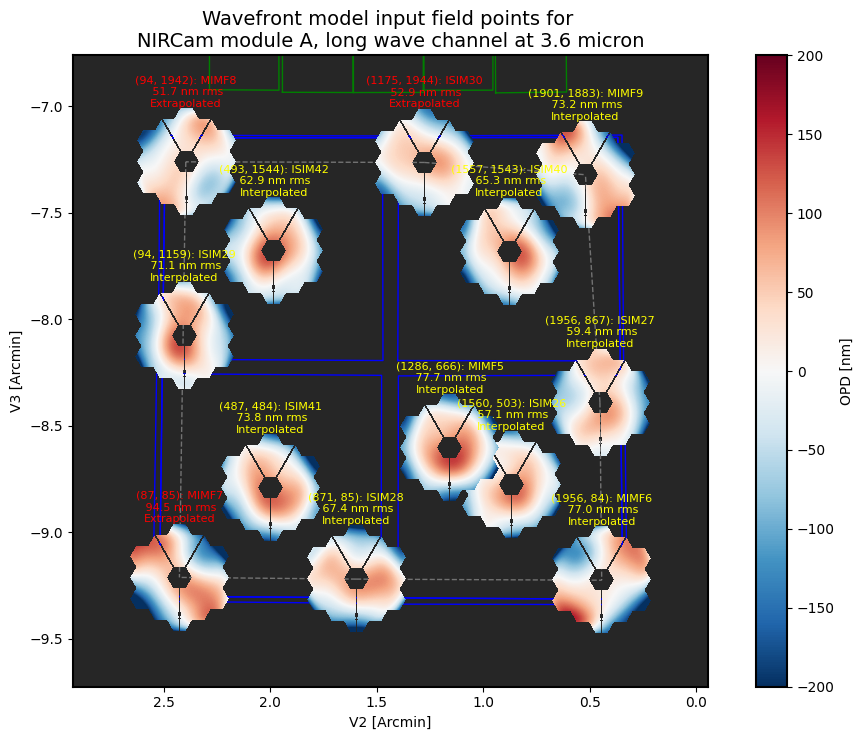

In [3]:
# Test for one instrument field of view

nircamlwa = webbpsf.NIRCam()
nircamlwa.filter='F356W'
nircamlwa.detector='NRCA5'

main_opd_plot_isimcv(nircamlwa, verbose=False, labelfontsize=8)

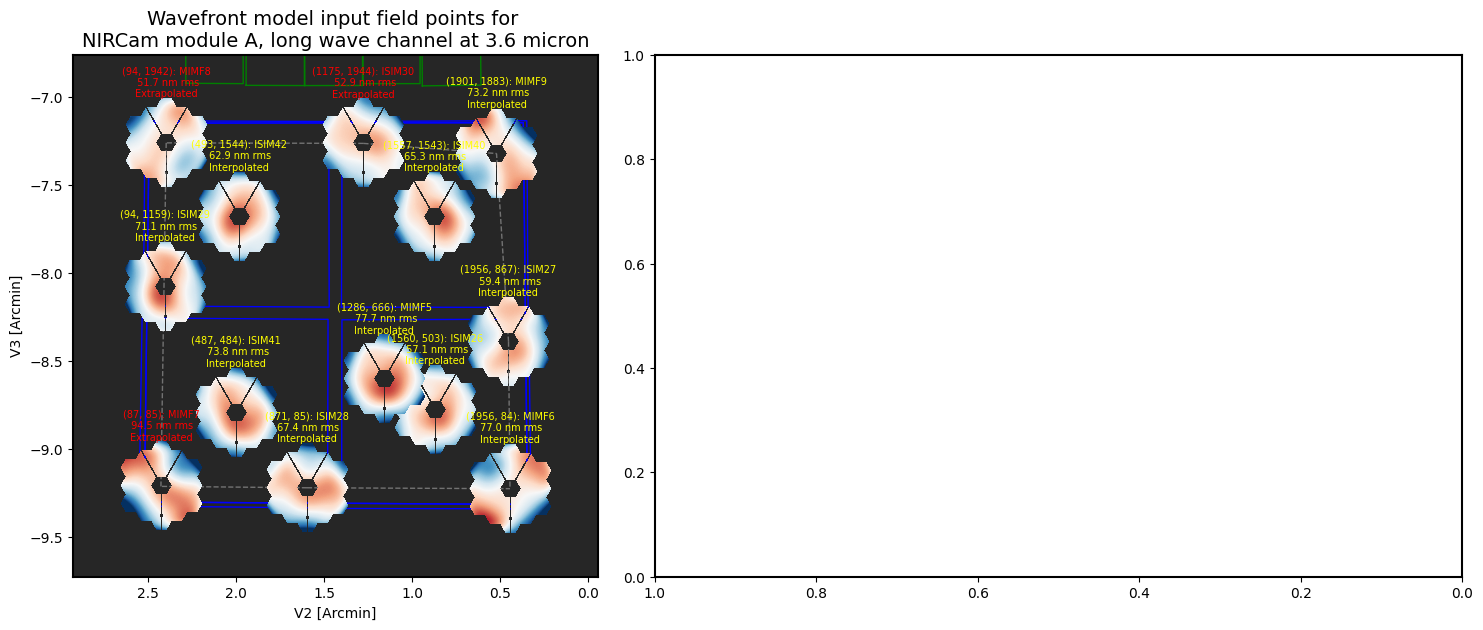

In [4]:
# Test we can plot into a subfigure. We will use this below...

fig, axes = plt.subplots(figsize=(15,6), ncols =2, gridspec_kw={'width_ratios': [1,1.5]})

main_opd_plot_isimcv(nircamlwa, verbose=False, ax=axes[0], colorbar=False, save=False)

In [5]:
# Prepare to iterate over all instrument fields of view. 
# Set up a list containing each instrument/module/channel we want:


nircamlwa = webbpsf.NIRCam()
nircamlwa.filter='F356W'
nircamlwa.detector='NRCA5'

nircamlwb = webbpsf.NIRCam()
nircamlwb.filter='F356W'
nircamlwb.detector='NRCB5'

nircamswa = webbpsf.NIRCam()
nircamswa.filter='F200W'
nircamswb = webbpsf.NIRCam()
nircamswb.filter='F200W'
nircamswb.detector='NRCB1'

niriss = webbpsf.NIRISS()
niriss.filter ='F200W'

fgs1 = webbpsf.FGS()
fgs1.detector = 'FGS1'
fgs2 = webbpsf.FGS()
fgs2.detector = 'FGS2'


all_sis = [nircamlwa, nircamlwb, nircamswa, nircamswb, 
           niriss, webbpsf.MIRI(), webbpsf.NIRSpec(), 
           fgs1, fgs2]

#all_sis = [niriss, fgs1, fgs2]


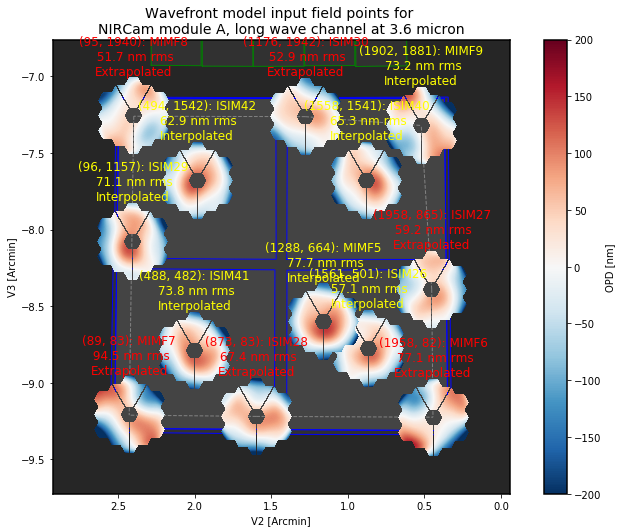

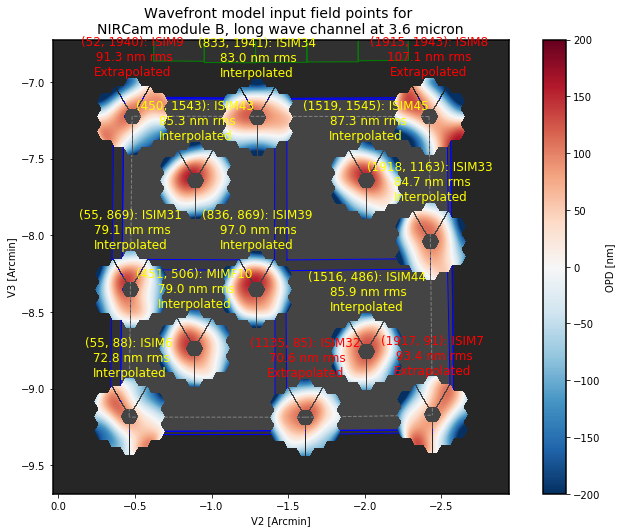

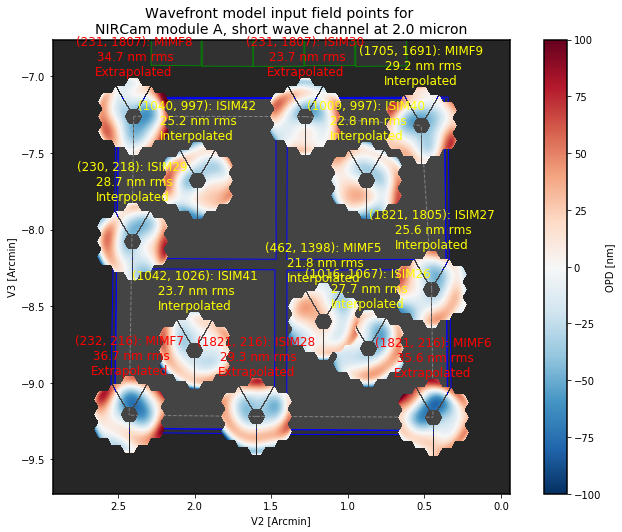

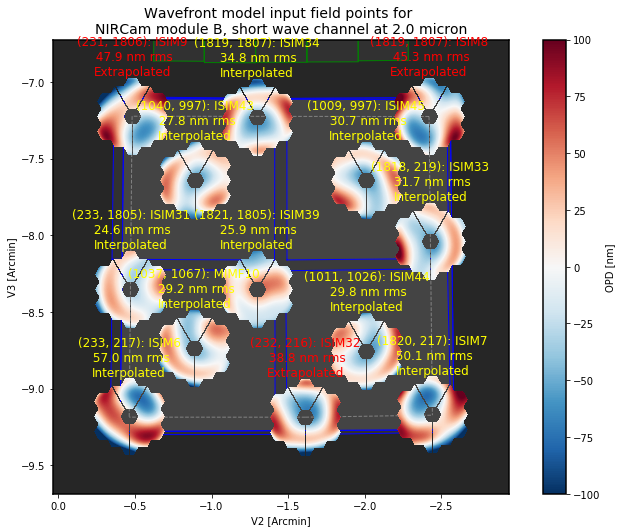

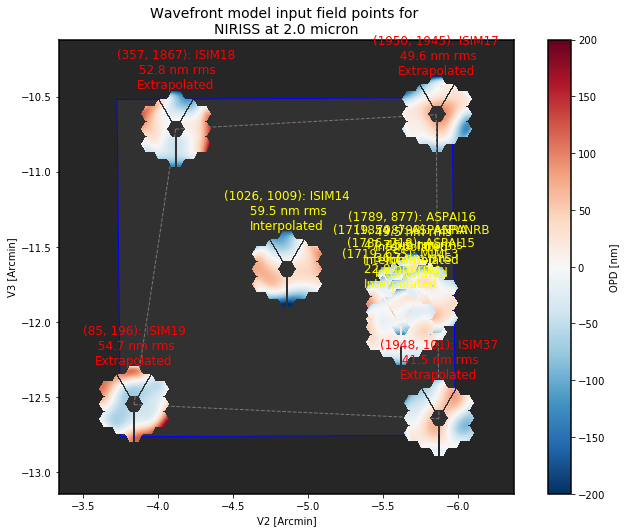

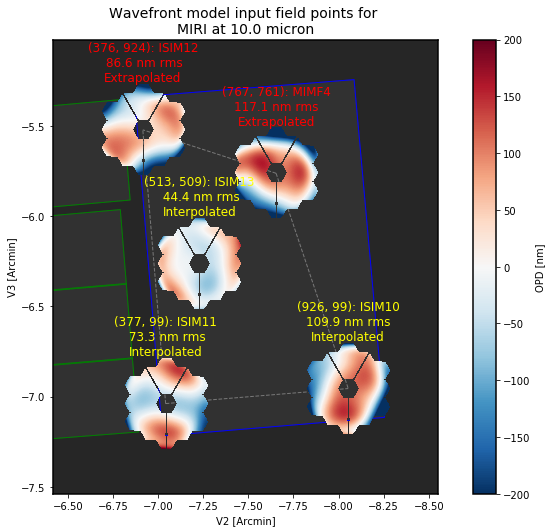

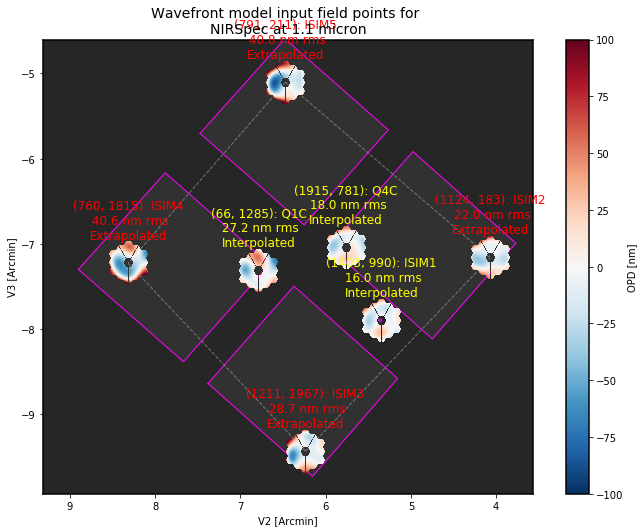

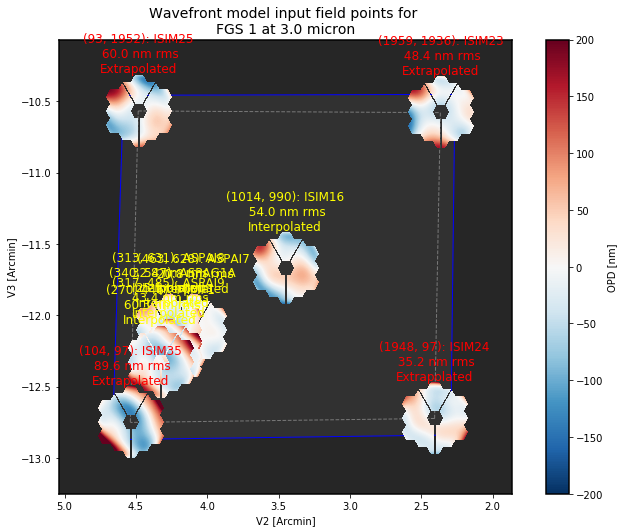

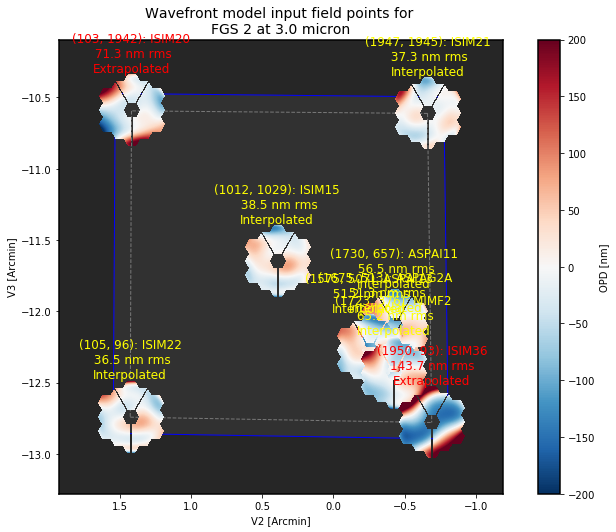

In [9]:
for si in all_sis:
    main_opd_plot_isimcv(si, verbose=False)

## Grid of interpolated OPDs over each full SI FOV

In [6]:
def grid_opd_plot(inst, nplots=None, wavelength=None, detector_position=None, size=0.3, vmax=None, 
                  verbose=False, ax=None, colorbar=True, save=True, **kwargs):
    """Top level function for plotting OPDs at an arbitrary evenly spaced grid, 
    i.e. NOT the input measured field  points
    """
    
    if wavelength is None:
        wavelengths, wt = inst._get_weights(nlambda=1)
        wavelength = wavelengths[0]
    if verbose:
        print("Plotting for wavelength {} microns".format(wavelength*1e6))
    
    if nplots is None:
        nplots = 4 if (inst.name == 'NIRCam' and inst.channel == 'short') else 7
    
    if vmax is None:
        vmax=100 if inst.name=='NIRSpec' or (inst.name=='NIRCam' and inst.channel=='short') else 200
        
    if ax is None: 
        plt.figure(figsize=(10,7.5))
        ax = plt.gca()
    
    wave = poppy.Wavefront(diam=6.6, npix=64, wavelength=wavelength)
    ztable = inst._get_aberrations().ztable

    entrance_pupil = inst.get_optical_system().planes[0]
    pupil_mask = entrance_pupil.get_transmission(wave) != 0
    pupil_mask = np.flipud(pupil_mask) # Flip to exit pupil orientation

    detsize=1024 if inst.name=='MIRI' else 2048
 
    from pysiaf.siaf import plot_main_apertures
    plot_main_apertures(units='arcmin', fill_color='white', zorder=-1, fill_alpha=0.05, ax=ax)
   
    # --- Draw the convex polygon around the allowed region
    ztable = inst._get_aberrations().ztable
    points = np.zeros( (len(ztable),2))
    for i, row in enumerate(ztable): 
        points[i] = (row['V2'], row['V3'])

    hull = scipy.spatial.ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], '--', color='0.75', zorder=-1, alpha=0.5)
        
    # --- Draw the field points
    if inst.name == 'NIRCam' and inst.channel == 'short' and inst.image_mask is None: 
        # NIRCam SW is a special case. 
        # Need to iterate over 4 detectors, and need to 
        # adjust the min/max to avoid ugly overlaps in the plots
        
        dets = list('NRC' + inst.module + str(i) for i in range(1,5))
        for det in dets:
            xmin=200 if det in ['NRCA3', 'NRCA4', 'NRCB1', 'NRCB2'] else 0
            xmax=1800 if det in ['NRCA1', 'NRCA2', 'NRCB3', 'NRCB4'] else 2048
            ymin=200 if det in ['NRCA2', 'NRCA4', 'NRCB1', 'NRCB3'] else 0
            ymax=1800 if det in ['NRCA1', 'NRCA3', 'NRCB2', 'NRCB4'] else 2048

            for x in np.linspace(xmin,xmax, nplots):
                for y in np.linspace(ymin,ymax, nplots):
                    inst.detector = det
                    detector_position = (int(x.clip(0,2047)), int(y.clip(0, 2047)))
                    im=disp1fieldpoint(inst, detector_position, wave, pupil_mask, 
                                    size=size, label=str(detector_position),
                                   vmax=vmax, labelvertalignment='bottom', ax=ax, **kwargs)
                    if not verbose: print('.', end='') # cheap progress bar to show it's running...
                        
    elif inst.name == 'NIRCam' and inst.channel == 'short' and inst.image_mask is not None: 
        # NIRCam SW is a special case. 
        #   NIRCam SW coronagraphy is a special case to exclude that special case -- 
        #   if a coronagraph mask is selected, do not iterate over detectors, and
        #    instead just run the default calculation path below. 

        # Need to iterate over 4 detectors, and need to 
        # adjust the min/max to avoid ugly overlaps in the plots
        #   NIRCam SW coronagraphy is a special case to exclude that special case -- 
        #   if a coronagraph mask is selected, do not iterate over detectors, and
        #    instead just run the default calculation path below. 
    
        dets = ['NRCA2', 'NRCA4']
        masks = ['MASK210R', 'MASKSWB']
        for det, mask in zip(dets, masks):
            inst.image_mask = mask
            
            xmin=200 if det in ['NRCA3', 'NRCA4', 'NRCB1', 'NRCB2'] else 0
            xmax=1800 if det in ['NRCA1', 'NRCA2', 'NRCB3', 'NRCB4'] else 2048
            ymin=200 if det in ['NRCA2', 'NRCA4', 'NRCB1', 'NRCB3'] else 0
            ymax=1800 if det in ['NRCA1', 'NRCA3', 'NRCB2', 'NRCB4'] else 2048

            for x in np.linspace(xmin,xmax, nplots):
                for y in np.linspace(ymin,ymax, nplots):
                    inst.detector = det
                    detector_position = (int(x.clip(0,2047)), int(y.clip(0, 2047)))
                    im=disp1fieldpoint(inst, detector_position, wave, pupil_mask, 
                                    size=size, label=str(detector_position),
                                   vmax=vmax, labelvertalignment='bottom', ax=ax, **kwargs)
                    if not verbose: print('.', end='') # cheap progress bar to show it's running...
                        
                        
                       
                        
    elif inst.name == 'NIRSpec':
        dets = ['NRS1', 'NRS2']
        for det in dets: 
            xmin = 1100 if det=='NRS1' else 100
            xmax = 950 if det=='NRS2' else 1950
            for x in np.linspace(xmin,xmax, int(np.ceil(nplots//2))):
                for y in np.linspace(0,detsize, nplots):
                    inst.detector = det
                    detector_position = (np.round(x.clip(0,2047)), np.round(y.clip(0, 2047)))
                    im=disp1fieldpoint(inst, detector_position, wave, pupil_mask, 
                                    size=size*1.5, label=str(detector_position),
                                   vmax=vmax, labelvertalignment='bottom', ax=ax, **kwargs)
                    if not verbose: print('.', end='') # cheap progress bar to show it's running...            
            
    else: 
        # All other cases don't involve iterating over multiple detectors
    
        for x in np.linspace(0,detsize, nplots):
            for y in np.linspace(0,detsize, nplots):
                detector_position = (int(x.clip(0,detsize-1)), int(y.clip(0, detsize-1)))
                im=disp1fieldpoint(inst, detector_position, wave, pupil_mask, size=size, label=str(detector_position),
                               vmax=vmax,  labelvertalignment='bottom', ax=ax, **kwargs)
                if not verbose: print('.', end='') # cheap progress bar to show it's running...

        
    if inst.name=='MIRI':
        ax.set_xlim(ztable['V2'].max()+1.0, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction
    elif inst.name=='NIRSpec':
        ax.set_xlim(ztable['V2'].max()+1.0, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction
    else:
        ax.set_xlim(ztable['V2'].max()+0.5, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction

        
    ax.set_ylim(ztable['V3'].min()-0.5, ztable['V3'].max()+0.5)
    ax.set_xlabel("V2 [Arcmin]")
    ax.set_ylabel("V3 [Arcmin]")
    ax.patch.set_facecolor('0.15')
    
    if inst.name == 'NIRCam':
        titlename = inst.name + " module "+inst.module + ", "+inst.channel+" wave"
        fn_name = "{}_{}_{}W".format(inst.name, inst.module, inst.channel[0].upper())
    elif inst.name == 'FGS':
        titlename = inst.name + " "+inst.detector[-1]
        fn_name = "{}_{}".format(inst.name, inst.detector[-1])
    else:
        titlename = fn_name = inst.name
                
    ax.set_title("Wavefront model results for {}\n at {:.1f} ({})".format(titlename, wave.wavelength.to(u.micron), inst.filter), 
             fontsize=14)

    if colorbar:
        cb=plt.colorbar(im)
        cb.set_label("OPD [nm]")
    plt.tight_layout()

    if save:
        plt.savefig("grid_of_opds_for_{}.pdf".format(fn_name), dpi=300)
    return fn_name


....................................

'NIRCam_A_SW'

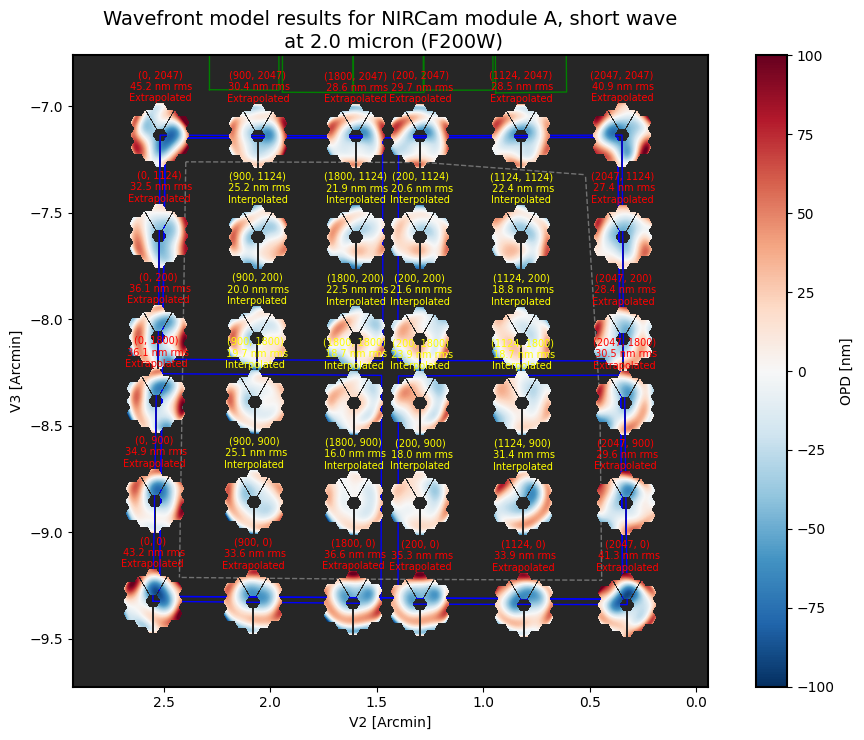

In [7]:
grid_opd_plot(webbpsf.NIRCam(), nplots=3)

In [11]:
def plot_input_and_interpolated_wfe(instrument, nplots=7, vmax=None, labelfontsize=5, save=True, **kwargs):
    """ Combined plot showing both the input ISIM CV points (left) 
    and the interpolated/extrapolated grid (right)
    
    """
    
    if vmax is None:
        vmax=100 if instrument.name=='NIRSpec' or (instrument.name=='NIRCam' and instrument.channel=='short') else 200

    fig, axes = plt.subplots(figsize=(12,5), ncols =2, gridspec_kw={'width_ratios': [1,1.5]})

    main_opd_plot_isimcv(instrument, verbose=False, ax=axes[0], colorbar=False, save=False,
                         labelfontsize=labelfontsize,
                         vmax=vmax,
                         size=0.35, # make individual OPD plots a bit smaller than the default 0.5
                         **kwargs) 

    fn_name = grid_opd_plot(instrument, nplots=nplots, ax=axes[1], vmax=vmax, 
                            save=False,
                           labelfontsize=labelfontsize-1, # smaller for this panel
                            labelvoffset=-0.03, # tweak placement
                           )

    axes[0].set_xlim(*axes[1].get_xlim())   
    axes[0].set_ylim(*axes[1].get_ylim())   

    
    if save: 
        plt.savefig("opds_combined_for_{}.pdf".format(fn_name), dpi=300)
        plt.savefig("opds_combined_for_{}.png".format(fn_name), dpi=300)
    return axes




.................................................

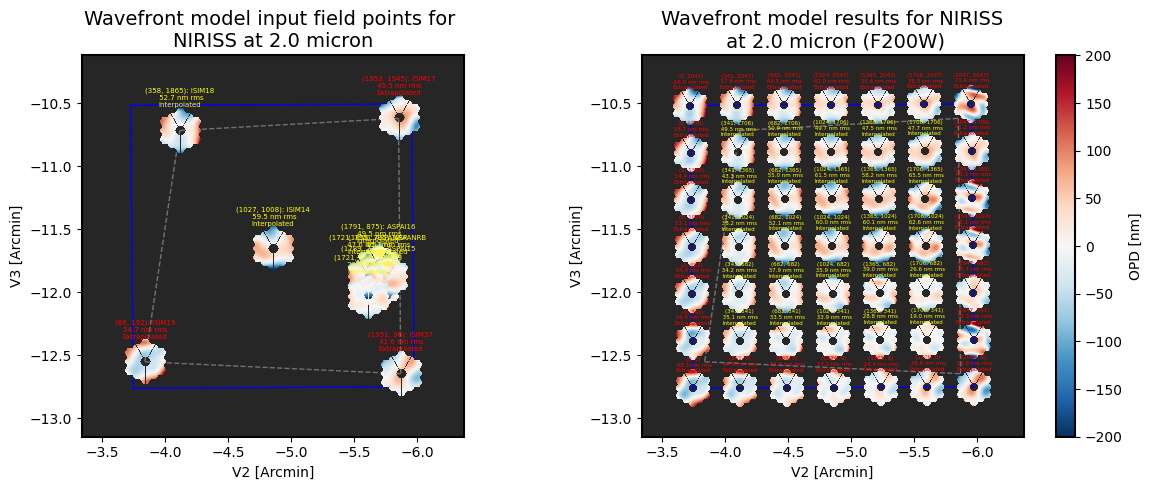

In [13]:
plot_input_and_interpolated_wfe(niriss, nplots=7, labelfontsize=5)

.................................................

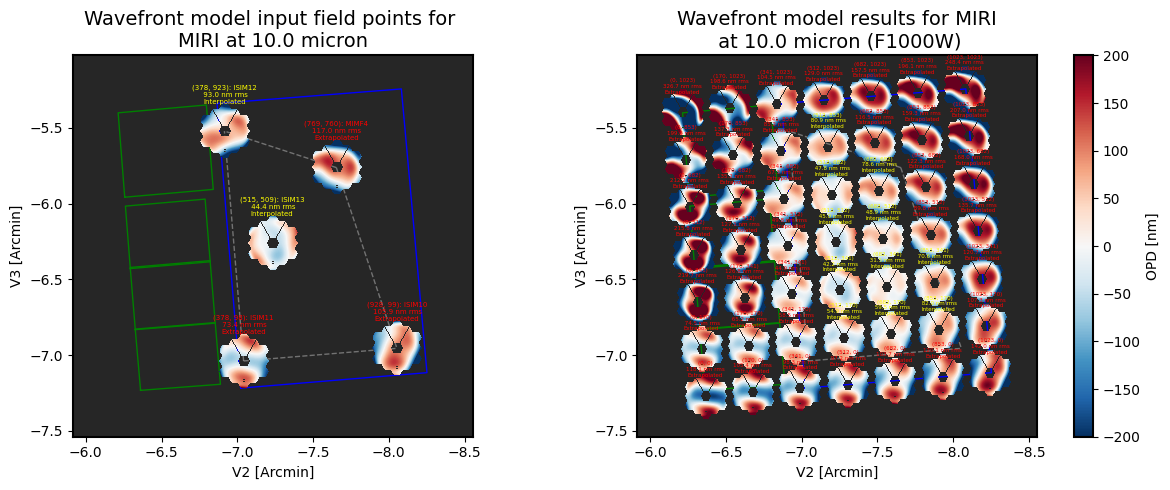

In [14]:
plot_input_and_interpolated_wfe(webbpsf.MIRI(), nplots=7, labelfontsize=5)

In [ ]:
plot_input_and_interpolated_wfe(nircamswa, nplots=4)
plot_input_and_interpolated_wfe(nircamswb, nplots=4)

In [ ]:
plot_input_and_interpolated_wfe(nircamlwa, nplots=7)
plot_input_and_interpolated_wfe(nircamlwb, nplots=7)

In [ ]:
plot_input_and_interpolated_wfe(webbpsf.NIRSpec(), nplots=7)

In [ ]:
plot_input_and_interpolated_wfe(fgs1, nplots=7)
plot_input_and_interpolated_wfe(fgs2, nplots=7)

.................................................

# Coronagraph Field Points in NIRCam

In [ ]:
nircamswa.filter='F210M'  # Nominal TA filter
nircamswa.image_mask = 'MASK210R'
nircamswa.pupil_mask = 'MASKRND'

In [17]:
zt = nircamswa._get_aberrations().ztable_full
zt

<Table length=72>
instrument field_point_name    V2      V3   PIXEL_X PIXEL_Y   DETECTOR  WFE_RMS  ... Zernike_31 Zernike_32 Zernike_33 Zernike_34 Zernike_35 Zernike_36    origin                          comments                       
  bytes9        bytes8      float64 float64  int64   int64    bytes11   float64  ...  float64    float64    float64    float64    float64    float64     bytes11                          bytes54                        
---------- ---------------- ------- ------- ------- ------- ----------- -------- ... ---------- ---------- ---------- ---------- ---------- ---------- ----------- ------------------------------------------------------
 NIRCamLWA           ISIM26   0.869  -8.777     535    -231   NIRCAMALW 2.51e-07 ...   3.65e-11  -7.62e-11   9.69e-14  -1.62e-13  -6.14e-13  -1.94e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM27   0.453  -8.389     140     127   NIRCAMALW 2.17e-07 ...  -3.37e-11  -5.31e-11  -1.62e-13   3.88e-13  -4.85e-13  -2.91e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM28   1.598  -9.219    1218    -639   NIRCAMALW 2.96e-07 ...   5.35e-11   1.14e-11   5.34e-11   1.23e-12  -2.07e-11  -9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA           ISIM29   2.404  -8.077    1984     421   NIRCAMALW 1.43e-07 ...  -2.76e-11   5.94e-12   1.94e-13   -4.2e-13  -1.94e-13   2.26e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM30   1.277  -7.263     910    1194   NIRCAMALW 1.35e-07 ...   2.45e-12   1.87e-12  -3.23e-14        0.0   3.23e-14        0.0 Zemax Model                                                    N/A
 NIRCamLWA           ISIM40   0.878   -7.68     533     796   NIRCAMALW  1.2e-07 ...  -4.78e-12   2.65e-12   1.29e-13  -3.23e-14  -1.62e-13  -1.29e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM41     2.0  -8.792    1597    -246   NIRCAMALW 2.32e-07 ...   3.74e-11    5.4e-11   -4.2e-13   5.17e-13  -5.49e-13   9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA           ISIM42   1.985  -7.678    1588     800   NIRCAMALW 1.21e-07 ...   -5.3e-12  -3.49e-12   1.29e-13   6.46e-14  -6.46e-14   1.62e-13 Zemax Model                                                    N/A
 NIRCamLWA            MIMF5   1.158  -8.604     805     -70   NIRCAMALW 1.93e-07 ...   3.45e-11  -2.95e-11   1.62e-13   9.69e-14  -5.17e-13  -9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA            MIMF6   0.444  -9.225     144    -643   NIRCAMALW 3.46e-07 ...  -9.22e-11  -1.97e-10   5.47e-11  -3.68e-11   -1.1e-11   1.65e-11 Zemax Model                                                    N/A
 NIRCamLWA            MIMF7   2.427  -9.211    1992    -635   NIRCAMALW 3.37e-07 ...  -9.21e-12   1.44e-10   3.87e-11   1.34e-11  -1.91e-11  -7.66e-12 Zemax Model                                                    N/A
 NIRCamLWA            MIMF8   2.397   -7.26    1983    1197   NIRCAMALW 1.39e-07 ...    7.3e-12  -1.74e-11   6.46e-14   6.14e-13   6.46e-14   2.26e-13 Zemax Model                                                    N/A
 NIRCamLWA            MIMF9   0.521  -7.321     189    1132   NIRCAMALW 1.29e-07 ...  -1.81e-12   1.71e-11   2.58e-13  -3.23e-13  -3.23e-14  -1.62e-13 Zemax Model                                                    N/A
 NIRCamLWA           ZLWB_A   0.787  -6.741     436    1688   NIRCAMALW 1.65e-07 ...   8.08e-12   4.39e-12  -2.58e-13  -6.46e-14   1.62e-13  -6.46e-14 Zemax Model                                                    N/A
 NIRCamLWA           ZSWB_A   1.127  -6.745     762    1688   NIRCAMALW 1.66e-07 ...   3.39e-12   2.42e-12  -6.46e-14        0.0   1.62e-13        0.0 Zemax Model                                                    N/A
 NIRCamLWA          Z430R_A   1.454  -6.753    1077    168

In [18]:
import os
import astropy.table as table

ztfull = table.Table.read(os.path.join(webbpsf.utils.get_webbpsf_data_path(), 'si_zernikes_coron_wfe.fits'))
ztfull

<Table length=72>
instrument field_point_name    V2      V3   PIXEL_X PIXEL_Y   DETECTOR  WFE_RMS  ... Zernike_31 Zernike_32 Zernike_33 Zernike_34 Zernike_35 Zernike_36    origin                          comments                       
  bytes9        bytes8      float64 float64  int64   int64    bytes11   float64  ...  float64    float64    float64    float64    float64    float64     bytes11                          bytes54                        
---------- ---------------- ------- ------- ------- ------- ----------- -------- ... ---------- ---------- ---------- ---------- ---------- ---------- ----------- ------------------------------------------------------
 NIRCamLWA           ISIM26   0.869  -8.777     535    -231   NIRCAMALW 2.51e-07 ...   3.65e-11  -7.62e-11   9.69e-14  -1.62e-13  -6.14e-13  -1.94e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM27   0.453  -8.389     140     127   NIRCAMALW 2.17e-07 ...  -3.37e-11  -5.31e-11  -1.62e-13   3.88e-13  -4.85e-13  -2.91e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM28   1.598  -9.219    1218    -639   NIRCAMALW 2.96e-07 ...   5.35e-11   1.14e-11   5.34e-11   1.23e-12  -2.07e-11  -9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA           ISIM29   2.404  -8.077    1984     421   NIRCAMALW 1.43e-07 ...  -2.76e-11   5.94e-12   1.94e-13   -4.2e-13  -1.94e-13   2.26e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM30   1.277  -7.263     910    1194   NIRCAMALW 1.35e-07 ...   2.45e-12   1.87e-12  -3.23e-14        0.0   3.23e-14        0.0 Zemax Model                                                    N/A
 NIRCamLWA           ISIM40   0.878   -7.68     533     796   NIRCAMALW  1.2e-07 ...  -4.78e-12   2.65e-12   1.29e-13  -3.23e-14  -1.62e-13  -1.29e-13 Zemax Model                                                    N/A
 NIRCamLWA           ISIM41     2.0  -8.792    1597    -246   NIRCAMALW 2.32e-07 ...   3.74e-11    5.4e-11   -4.2e-13   5.17e-13  -5.49e-13   9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA           ISIM42   1.985  -7.678    1588     800   NIRCAMALW 1.21e-07 ...   -5.3e-12  -3.49e-12   1.29e-13   6.46e-14  -6.46e-14   1.62e-13 Zemax Model                                                    N/A
 NIRCamLWA            MIMF5   1.158  -8.604     805     -70   NIRCAMALW 1.93e-07 ...   3.45e-11  -2.95e-11   1.62e-13   9.69e-14  -5.17e-13  -9.69e-14 Zemax Model                                                    N/A
 NIRCamLWA            MIMF6   0.444  -9.225     144    -643   NIRCAMALW 3.46e-07 ...  -9.22e-11  -1.97e-10   5.47e-11  -3.68e-11   -1.1e-11   1.65e-11 Zemax Model                                                    N/A
 NIRCamLWA            MIMF7   2.427  -9.211    1992    -635   NIRCAMALW 3.37e-07 ...  -9.21e-12   1.44e-10   3.87e-11   1.34e-11  -1.91e-11  -7.66e-12 Zemax Model                                                    N/A
 NIRCamLWA            MIMF8   2.397   -7.26    1983    1197   NIRCAMALW 1.39e-07 ...    7.3e-12  -1.74e-11   6.46e-14   6.14e-13   6.46e-14   2.26e-13 Zemax Model                                                    N/A
 NIRCamLWA            MIMF9   0.521  -7.321     189    1132   NIRCAMALW 1.29e-07 ...  -1.81e-12   1.71e-11   2.58e-13  -3.23e-13  -3.23e-14  -1.62e-13 Zemax Model                                                    N/A
 NIRCamLWA           ZLWB_A   0.787  -6.741     436    1688   NIRCAMALW 1.65e-07 ...   8.08e-12   4.39e-12  -2.58e-13  -6.46e-14   1.62e-13  -6.46e-14 Zemax Model                                                    N/A
 NIRCamLWA           ZSWB_A   1.127  -6.745     762    1688   NIRCAMALW 1.66e-07 ...   3.39e-12   2.42e-12  -6.46e-14        0.0   1.62e-13        0.0 Zemax Model                                                    N/A
 NIRCamLWA          Z430R_A   1.454  -6.753    1077    168

In [19]:
mask = [val.startswith('Z') for val in ztfull['field_point_name']]

ztfull[mask]

<Table length=20>
instrument field_point_name    V2      V3   PIXEL_X PIXEL_Y   DETECTOR  WFE_RMS  ... Zernike_31 Zernike_32 Zernike_33 Zernike_34 Zernike_35 Zernike_36    origin                          comments                       
  bytes9        bytes8      float64 float64  int64   int64    bytes11   float64  ...  float64    float64    float64    float64    float64    float64     bytes11                          bytes54                        
---------- ---------------- ------- ------- ------- ------- ----------- -------- ... ---------- ---------- ---------- ---------- ---------- ---------- ----------- ------------------------------------------------------
 NIRCamLWA           ZLWB_A   0.787  -6.741     436    1688   NIRCAMALW 1.65e-07 ...   8.08e-12   4.39e-12  -2.58e-13  -6.46e-14   1.62e-13  -6.46e-14 Zemax Model                                                    N/A
 NIRCamLWA           ZSWB_A   1.127  -6.745     762    1688   NIRCAMALW 1.66e-07 ...   3.39e-12   2.42e-12  -6.46e-14        0.0   1.62e-13        0.0 Zemax Model                                                    N/A
 NIRCamLWA          Z430R_A   1.454  -6.753    1077    1682   NIRCAMALW 1.71e-07 ...   2.39e-12   3.94e-12  -3.23e-14  -9.69e-14   1.94e-13   6.46e-14 Zemax Model                                                    N/A
 NIRCamLWA          Z335R_A   1.792  -6.759    1402    1678   NIRCAMALW 1.76e-07 ...   6.17e-12   6.01e-12  -2.91e-13  -1.94e-13   2.26e-13   1.29e-13 Zemax Model                                                    N/A
 NIRCamLWA          Z210R_A   2.121  -6.754    1719    1682   NIRCAMALW 1.82e-07 ...   1.51e-11   5.88e-12  -7.43e-13        0.0   2.26e-13   1.94e-13 Zemax Model                                                    N/A
 NIRCamLWB           ZSWB_B  -0.787  -6.741     382     401   NIRCAMBLW 1.65e-07 ...   8.08e-12   4.39e-12  -2.58e-13  -6.46e-14   1.62e-13  -6.46e-14 Zemax Model These V2/V3 coordinates are not centerd on the B masks
 NIRCamLWB           ZLWB_B  -1.127  -6.745     708     401   NIRCAMBLW 1.66e-07 ...   3.39e-12   2.42e-12  -6.46e-14        0.0   1.62e-13        0.0 Zemax Model These V2/V3 coordinates are not centerd on the B masks
 NIRCamLWB          Z430R_B  -1.454  -6.753    1022     406   NIRCAMBLW 1.71e-07 ...   2.39e-12   3.94e-12  -3.23e-14  -9.69e-14   1.94e-13   6.46e-14 Zemax Model These V2/V3 coordinates are not centerd on the B masks
 NIRCamLWB          Z335R_B  -1.792  -6.759    1346     411   NIRCAMBLW 1.76e-07 ...   6.17e-12   6.01e-12  -2.91e-13  -1.94e-13   2.26e-13   1.29e-13 Zemax Model These V2/V3 coordinates are not centerd on the B masks
 NIRCamLWB          Z210R_B  -2.121  -6.754    1663     406   NIRCAMBLW 1.82e-07 ...   1.51e-11   5.88e-12  -7.43e-13        0.0   2.26e-13   1.94e-13 Zemax Model These V2/V3 coordinates are not centerd on the B masks
 NIRCamSWA           ZLWB_A   0.787  -6.741    1155     543 NIRCAMASW_4 1.58e-07 ...   2.25e-11  -5.01e-11   -8.9e-13   1.21e-12   3.39e-13  -2.76e-13 Zemax Model                                                    N/A
 NIRCamSWA           ZSWB_A   1.127  -6.745     492     549 NIRCAMASW_4 1.56e-07 ...  -1.72e-11  -2.84e-11   2.12e-13   6.36e-13   2.12e-13        0.0 Zemax Model                                                    N/A
 NIRCamSWA          Z430R_A   1.454  -6.753    2043     562 NIRCAMASW_2 1.55e-07 ...  -2.89e-11    5.7e-12   5.94e-13  -2.33e-13   3.39e-13   2.12e-14 Zemax Model                                                    N/A
 NIRCamSWA          Z335R_A   1.792  -6.759    1382     577 NIRCAMASW_2 1.57e-07 ...   -1.1e-11   4.05e-11  -8.48e-14  -1.06e-12   3.39e-13   1.48e-13 Zemax Model                                                    N/A
 NIRCamSWA          Z210R_A   2.121  -6.754     738     572 NIRCAMASW_2 1.61e-07 ...   3.67e-11   6.42e-11  -1.67e-12  -1.34e-12    3.6e-13   3.18e-13 Zemax Model                                                    N/A
 NIRCamSWB           ZSWB_B  -0.787  -6.741     882     60

(-9.725, -6.241)

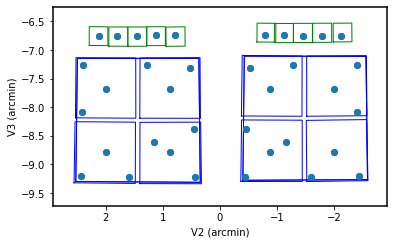

In [20]:
ztable = ztfull

plt.scatter(ztfull['V2'], ztfull['V3'])
plt.gca().set_aspect('equal')

pysiaf.siaf.plot_main_apertures(units='arcmin', fill_color='white', zorder=-1, fill_alpha=0.05)


plt.xlim(ztable['V2'].max()+0.5, ztable['V2'].min()-0.5 )  # Note, this flips V2 axis direction
plt.ylim(ztable['V3'].min()-0.5, ztable['V3'].max()+0.5)



In [21]:
nircamswa.image_mask = 'MASKSWB'

In [ ]:
zt

In [ ]:
main_opd_plot_isimcv(nircamswa, verbose=True)

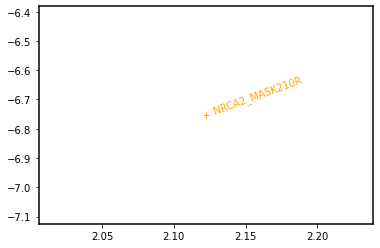

In [24]:
def plot_coron_location(inst, apername, ax = None, **kwargs):
    v2,v3 = inst.siaf.apertures[apername].V2Ref, inst.siaf.apertures[apername].V3Ref
    
    if ax is None:
        ax = plt.gca()
    ax.scatter(v2/60, v3/60, marker='+', color='orange')
    ax.text(v2/60, v3/60, f"  {apername}", color='orange', rotation=20, **kwargs)

    
plot_coron_location(nircamswa, 'NRCA2_MASK210R')

disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA2
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA2
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA2
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA4
disp1row: set det=NRCA2
disp1row: set det=NRCA2
disp1row: set det=NRCA2
................................

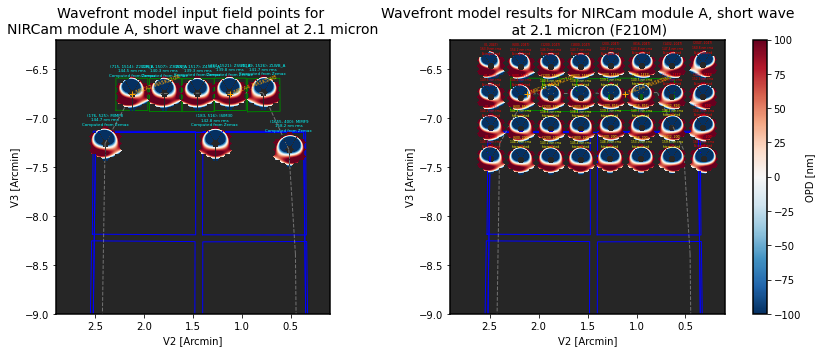

In [25]:
axes = plot_input_and_interpolated_wfe(nircamswa, nplots=4, labelfontsize=4, save=False)

# Adjust plot region for NIRCam SW coronagraphy
for ax in axes: 
    ax.set_xlim(2.9, 0.1)
    ax.set_ylim(-6.2-2.8, -6.2)
    plot_coron_location(nircamswa, 'NRCA2_MASK210R', ax=ax, fontsize=5)
    plot_coron_location(nircamswa, 'NRCA4_MASKSWB', ax=ax, fontsize=5)
    
fn_name = 'NIRCam_SW_coronagraphy'
    
plt.savefig("opds_combined_for_{}.pdf".format(fn_name), dpi=300)
plt.savefig("opds_combined_for_{}.png".format(fn_name), dpi=300)


## NRC Coron LW

In [26]:
nircamlwa.filter='F335M'  # Nominal TA filter
nircamlwa.image_mask = 'MASK335R'
nircamlwa.pupil_mask = 'MASKRND'

.................................................

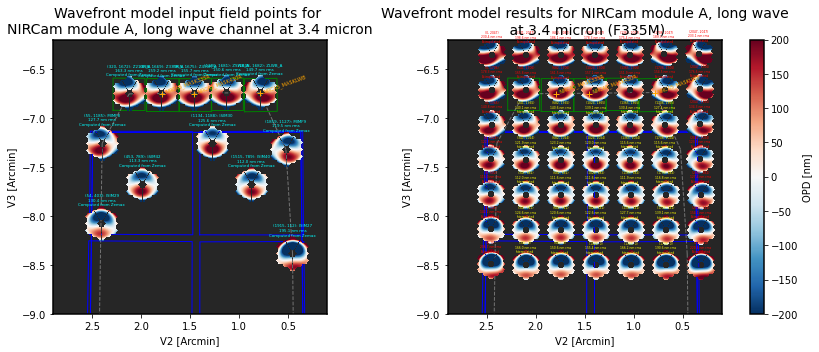

In [27]:
axes = plot_input_and_interpolated_wfe(nircamlwa, nplots=7, labelfontsize=4, save=False)

# Adjust plot region for NIRCam SW coronagraphy
for ax in axes: 
    ax.set_xlim(2.9, 0.1)
    ax.set_ylim(-6.2-2.8, -6.2)
    plot_coron_location(nircamswa, 'NRCA5_MASK335R', ax=ax, fontsize=5)
    plot_coron_location(nircamswa, 'NRCA5_MASK430R', ax=ax, fontsize=5)
    plot_coron_location(nircamswa, 'NRCA5_MASKLWB', ax=ax, fontsize=5)
    
fn_name = 'NIRCam_LW_coronagraphy'
    
plt.savefig("opds_combined_for_{}.pdf".format(fn_name), dpi=300)
plt.savefig("opds_combined_for_{}.png".format(fn_name), dpi=300)
